# Run CoCiP over a flight

This tutorial walks through an example of running the [Contrail Cirrus Predicition (CoCiP)](https://gmd.copernicus.org/articles/5/543/2012/) model evaluation along a flight trajectory.

## References

- Schumann, U. “A Contrail Cirrus Prediction Model.” Geoscientific Model Development 5, no. 3 (May 3, 2012): 543–80. https://doi.org/10.5194/gmd-5-543-2012.
- Schumann, U., B. Mayer, K. Graf, and H. Mannstein. “A Parametric Radiative Forcing Model for Contrail Cirrus.” Journal of Applied Meteorology and Climatology 51, no. 7 (July 2012): 1391–1406. https://doi.org/10.1175/JAMC-D-11-0242.1.
- Teoh, Roger, Ulrich Schumann, Arnab Majumdar, and Marc E. J. Stettler. “Mitigating the Climate Forcing of Aircraft Contrails by Small-Scale Diversions and Technology Adoption.” Environmental Science & Technology 54, no. 5 (March 3, 2020): 2941–50. https://doi.org/10.1021/acs.est.9b05608.
- Teoh, Roger, Ulrich Schumann, Edward Gryspeerdt, Marc Shapiro, Jarlath Molloy, George Koudis, Christiane Voigt, and Marc Stettler. “Aviation Contrail Climate Effects in the North Atlantic from 2016&ndash;2021.” Atmospheric Chemistry and Physics Discussions, March 30, 2022, 1–27. https://doi.org/10.5194/acp-2022-169.

In [1]:
import pandas as pd
import xarray as xr

from pycontrails import Flight
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling
from pycontrails.physics import units

## Load Flight

Load flight trajectory from dataset prepared by Roger Teoh in https://doi.org/10.5194/acp-2022-169

In [2]:
# load flight waypoints
df_flight = pd.read_csv("flight.csv")
df_flight.head()

,Longitude (degrees),Latitude (degrees),Altitude (feet),UTC time,True airspeed (m s-1),Mach Number,Aircraft mass (kg),Fuel mass flow rate (kg s-1),Overall propulsion efficiency,nvPM number emissions index (kg-1),ICAO Aircraft Type,Wingspan (m)
0,-10.070,55.185,36000,1546651185,230.858,0.791,236479.000,1.654,0.4,1500000000000000,A359,64.75
1,-10.273,55.222,36000,1546651245,230.682,0.790,236379.755,1.657,0.4,1500000000000000,A359,64.75
2,-10.476,55.258,36000,1546651305,230.563,0.789,236280.355,1.659,0.4,1500000000000000,A359,64.75
3,-10.680,55.295,36000,1546651365,230.501,0.789,236180.791,1.661,0.4,1500000000000000,A359,64.75
4,-10.883,55.331,36000,1546651425,230.476,0.789,236081.128,1.662,0.4,1500000000000000,A359,64.75


In [3]:
# constant properties along the length of the flight
attrs = {
    "flight_id": "fid",
    "aircraft_type": df_flight["ICAO Aircraft Type"].values[0],
    "wingspan": df_flight["Wingspan (m)"].values[0],
}

Process the flight into a format expected by `pycontrails`. See [pycontrails.Flight](https://py.contrails.org/api/pycontrails.Flight.html#pycontrails.Flight) for interface details.

In [4]:
# convert UTC timestamp to np.datetime64
df_flight["time"] = pd.to_datetime(df_flight["UTC time"], origin="unix", unit="s")

# set altitude in m
df_flight["altitude"] = units.ft_to_m(df_flight["Altitude (feet)"])

# rename a few columns for compatibility with `Flight` requirements
df_flight = df_flight.rename(
    columns={
        "Longitude (degrees)": "longitude",
        "Latitude (degrees)": "latitude",
        "True airspeed (m s-1)": "true_airspeed",
        "Mach Number": "mach_number",
        "Aircraft mass (kg)": "aircraft_mass",
        "Fuel mass flow rate (kg s-1)": "fuel_flow",
        "Overall propulsion efficiency": "engine_efficiency",
        "nvPM number emissions index (kg-1)": "nvpm_ei_n",
    }
)

# clean up a few columns before building Flight class
df_flight = df_flight.drop(
    columns=["ICAO Aircraft Type", "Wingspan (m)", "UTC time", "Altitude (feet)"]
)

fl = Flight(data=df_flight, attrs=attrs)
fl

Flight [10 keys x 162 length, 4 attributes]
	Keys: longitude, latitude, true_airspeed, mach_number, aircraft_mass, ..., altitude
	Attributes:
	time                [2019-01-05 01:19:45, 2019-01-05 04:00:21]
	longitude           [-50.0, -10.07]
	latitude            [55.185, 61.089]
	altitude            [10972.800000000001, 10972.800000000001]
	flight_id           fid
	aircraft_type       A359
	wingspan            64.75
	crs                 EPSG:4326

## Load meteorology from ECMWF

In [5]:
# get met domain from Flight
time = (
    pd.to_datetime(fl["time"][0]).floor("H"),
    pd.to_datetime(fl["time"][-1]).ceil("H") + pd.Timedelta("10H"),
)

# select pressure levels
pressure_levels = [
    400,
    350,
    300,
    250,
    225,
    200,
    175,
    150,
]

In [6]:
# downloads met data from CDS
era5pl = ERA5(time=time, variables=Cocip.met_variables, pressure_levels=pressure_levels)
era5sl = ERA5(
    time=time,
    variables=Cocip.rad_variables,
)

In [7]:
# create `MetDataset` from sources
met = era5pl.open_metdataset(xr_kwargs=dict(parallel=False))
rad = era5sl.open_metdataset(xr_kwargs=dict(parallel=False))

## Set up model

In [8]:
params = {
    "process_emissions": False,
    "verbose_outputs": True,
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=0.98),
}
cocip = Cocip(met=met, rad=rad, params=params)

## Run model

In [9]:
fl_out = cocip.eval(source=fl)

## Review output

The output flight has the original flight data with many new variables added from the evaluation.

In [10]:
fl_out

Flight [65 keys x 162 length, 8 attributes]
	Keys: waypoint, longitude, latitude, true_airspeed, mach_number, ..., cocip
	Attributes:
	time                [2019-01-05 01:19:45, 2019-01-05 04:00:21]
	longitude           [-50.0, -10.07]
	latitude            [55.185, 61.089]
	altitude            [10972.800000000001, 10972.800000000001]
	flight_id           fid
	aircraft_type       A359
	wingspan            64.75
	crs                 EPSG:4326
	rhi_adj             0.98
	humidity_scaling_nameconstant_scale
	humidity_scaling_formularhi -> rhi / rhi_adj
	humidity_scaling_rhi_adj0.98

In [11]:
fl_out.dataframe.columns

Index(['waypoint', 'longitude', 'latitude', 'true_airspeed', 'mach_number',
       'aircraft_mass', 'fuel_flow', 'engine_efficiency', 'nvpm_ei_n', 'time',
       'altitude', 'flight_id', 'level', 'air_pressure', 'air_temperature',
       'specific_humidity', 'u_wind', 'v_wind', 'rhi', 'tau_cirrus',
       'specific_cloud_ice_water_content', 'rho_air', 'segment_length',
       'sin_a', 'cos_a', 'G', 'T_sat_liquid', 'rh', 'rh_critical_sac', 'sac',
       'T_critical_sac', 'width', 'depth', 'rhi_1', 'air_temperature_1',
       'specific_humidity_1', 'altitude_1', 'persistent_1', 'dT_dz', 'ds_dz',
       'dz_max', 'rho_air_1', 'iwc_1', 'n_ice_per_m_1', 'ef', 'contrail_age',
       'sdr_mean', 'sdr_min', 'sdr_max', 'rsr_mean', 'rsr_min', 'rsr_max',
       'olr_mean', 'olr_min', 'olr_max', 'rf_sw_mean', 'rf_sw_min',
       'rf_sw_max', 'rf_lw_mean', 'rf_lw_min', 'rf_lw_max', 'rf_net_mean',
       'rf_net_min', 'rf_net_max', 'cocip'],
      dtype='object')

The `cocip` variable describes where persistent contrails form. It can take on values:

- 1: Persistent contrails form
- 0: No persistent contrails form

In [12]:
fl_out["cocip"]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

The model class contains information about the contrail created:

- `cocip.source` the original input flight
- `cocip.contrail` will be defined as a `pandas` DataFrame if a contrail is created. 
- `cocip.contrail_dataset` is the same data but formatted as an `xarray` Dataset.

In [13]:
cocip.contrail

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,dn_dt_agg,dn_dt_turb,rf_sw,rf_lw,rf_net,persistent,ef,timestep,age_hours,dt_integration
index,,,,,,,,,,,,,,,,,,,,,
0,30,fid,2019-01-05 01:49:44,2019-01-05 02:00:00,0 days 00:10:16,-16.244715,56.380496,10911.666384,229.487285,True,...,4.054186e-19,2.136606e-05,0.0,1.127125,1.127125,True,6.611733e+09,0,0.171111,0 days 00:10:16
1,31,fid,2019-01-05 01:50:44,2019-01-05 02:00:00,0 days 00:09:16,-16.478943,56.425431,10909.386653,229.569577,True,...,7.046055e-19,2.260526e-05,0.0,2.548865,2.548865,True,1.110261e+10,0,0.154444,0 days 00:09:16
2,32,fid,2019-01-05 01:51:44,2019-01-05 02:00:00,0 days 00:08:16,-16.714843,56.468946,10907.569588,229.635186,True,...,9.599278e-19,2.345836e-05,0.0,3.810883,3.810883,True,1.252899e+10,0,0.137778,0 days 00:08:16
3,33,fid,2019-01-05 01:52:44,2019-01-05 02:00:00,0 days 00:07:16,-16.952033,56.509944,10906.268956,229.682157,True,...,1.041877e-18,2.424313e-05,0.0,4.152540,4.152540,True,9.913124e+09,0,0.121111,0 days 00:07:16
4,34,fid,2019-01-05 01:53:44,2019-01-05 02:00:00,0 days 00:06:16,-17.189068,56.549382,10905.391558,229.713847,True,...,1.040693e-18,2.541746e-05,0.0,3.974480,3.974480,True,6.425664e+09,0,0.104444,0 days 00:06:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,56,fid,2019-01-05 02:15:48,2019-01-05 10:00:00,0 days 00:00:00,-19.526755,70.430843,11268.802342,216.924473,False,...,6.951854e-19,1.320218e-06,0.0,2.277657,2.277657,True,0.000000e+00,16,0.000000,0 days 00:30:00
0,55,fid,2019-01-05 02:14:48,2019-01-05 10:30:00,0 days 08:15:12,-18.420785,71.185723,10938.834904,228.508407,True,...,1.818233e-18,2.258728e-06,0.0,2.383284,2.383284,True,5.485187e+12,17,8.253333,0 days 00:30:00
1,56,fid,2019-01-05 02:15:48,2019-01-05 10:30:00,0 days 00:00:00,-18.657576,71.137672,11294.592303,216.044071,False,...,4.415182e-19,1.167024e-06,0.0,1.779552,1.779552,True,0.000000e+00,17,0.000000,0 days 00:30:00


We can visualize the contrail on top of the original flight trajectory using pandas plotting capabilities

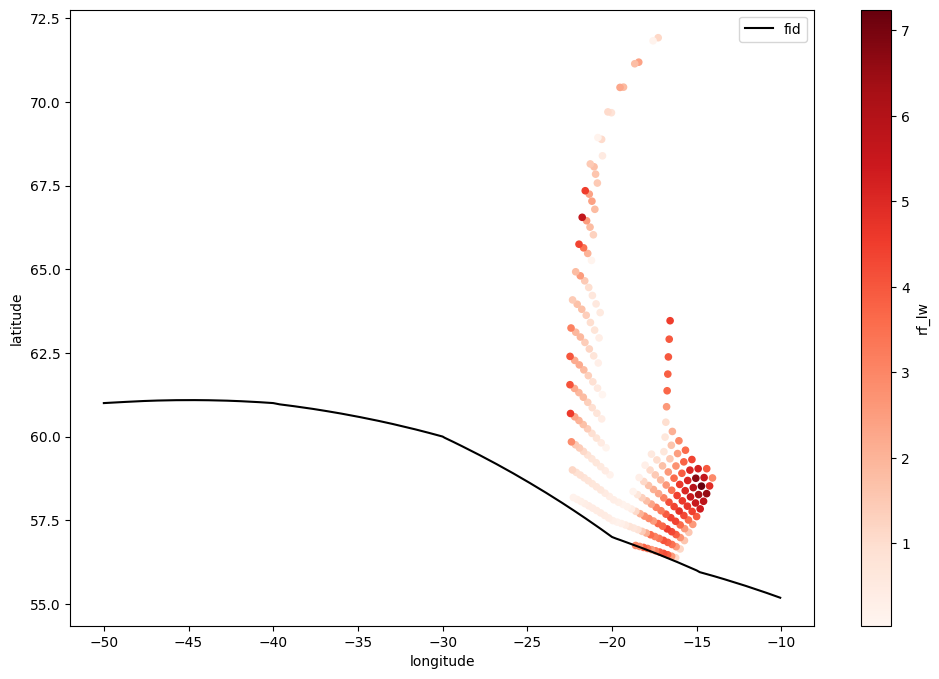

In [14]:
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl.attrs["flight_id"], figsize=(12, 8)
)
cocip.contrail.plot.scatter("longitude", "latitude", c="rf_lw", cmap="Reds", ax=ax);

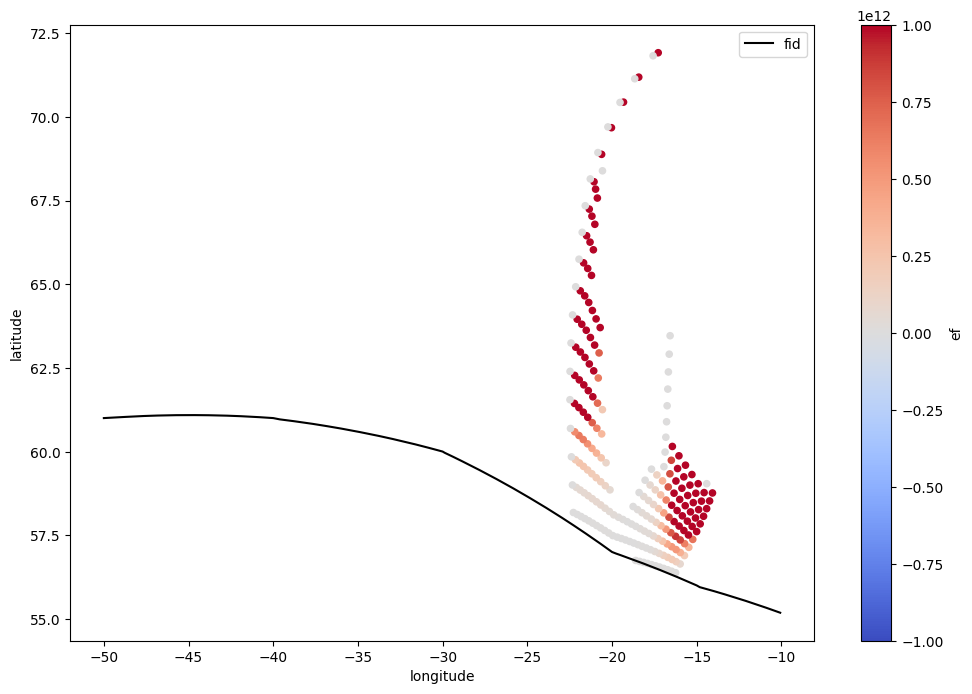

In [15]:
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl.attrs["flight_id"], figsize=(12, 8)
)
cocip.contrail.plot.scatter(
    "longitude", "latitude", c="ef", cmap="coolwarm", vmin=-1e12, vmax=1e12, ax=ax
);